<a href="https://colab.research.google.com/github/vestinabert/Image_Processing/blob/main/Feature_Extraction_And_Image_Stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# Upload files
uploaded = files.upload()

# List uploaded files
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")


Saving italijoskelione011.jpg to italijoskelione011.jpg
Saving 02025.jpg to 02025.jpg
Uploaded file: italijoskelione011.jpg
Uploaded file: 02025.jpg


In [2]:
import os

# List files in the current directory
print("Files in current directory:")
print(os.listdir())


Files in current directory:
['.config', '02025.jpg', 'italijoskelione011.jpg', 'sample_data']


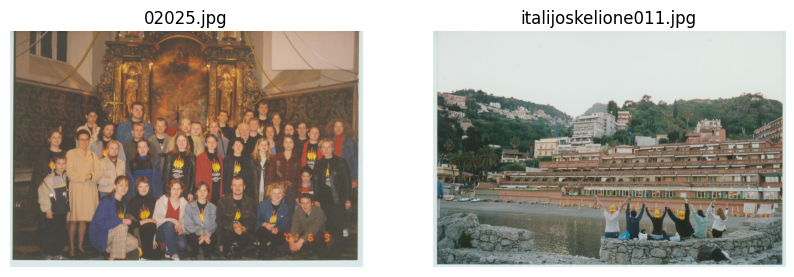

In [3]:
import cv2
import matplotlib.pyplot as plt
import os

# List uploaded images
image_files = [f for f in os.listdir() if f.lower().endswith(('jpg'))]

# Display all images
plt.figure(figsize=(10, 5))

for i, img_file in enumerate(image_files):
    img = cv2.imread(img_file)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.subplot(1, len(image_files), i+1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')

plt.show()
